<a href="https://colab.research.google.com/github/liao771018/Team-Project/blob/main/Grad_CAM_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.applications.efficientnet import preprocess_input
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os

tf.__version__

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_SIZE = 224

In [ ]:
model_path = '/content/drive/MyDrive/12_團體專題_第四組/02_模型/09_EfficientNetB4/EfficientNetB4_TP_3_best.h5'

model = models.load_model(model_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

ImageNet class map: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
def gradcam(model, img, layer_name='top_bn'):

    preds = model.predict(img)
    pred_class_idx = np.argmax(preds[0])
    
    idx2cls = {
            0: 'bigfin squid',
            1: 'neritic squid',
            2: 'octopus',
            3: 'squid',
            4: 'cuttlefish'
          }   
    pred_class_name = idx2cls[pred_class_idx]

    # build a new model for Grad-CAM
    # outputs = [model.get_layer(layer_name).output]
    # outputs.append(model.output)
    outputs = [model.get_layer(layer_name).output, 
           model.output]
    model_gradcam = models.Model([model.inputs], outputs) 
    # input: img, output: [layer_output, class_output]
    

    with tf.GradientTape() as tape:
        conv_output, preds = model_gradcam(img)
        pred_output = preds[:, pred_class_idx]
        grads = tape.gradient(pred_output, conv_output)
        print('conv_output.shape', conv_output.shape)
        print('grads.shape', grads.shape)
    
    pooled_grads = tf.keras.backend.sum(grads, axis=(0, 1, 2)) # (2048, )
    print('pooled_grads.shape ', pooled_grads.shape)
    heatmap = pooled_grads * conv_output
    print('heatmaps.shape ', heatmap.shape)
    heatmap = tf.keras.backend.mean(heatmap, axis=-1)[0, :, :].numpy()
    
    return heatmap, pred_class_name

In [ ]:
def processing_image(img_path):
    # 圖片預處理
    img = cv2.imread(img_path)[:, :, ::-1]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img, axis=0)
    
    x = preprocess_input(x)
    return x

In [ ]:
def plot_heatmap(heatmap, img_path):
    # 建立heatmap與 input img 疊圖
    img = cv2.imread(img_path)[:, :, ::-1]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # normalization
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)

    # show input img
    plt.figure(figsize=(10, 5))    
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    # show heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img) # original img
    plt.imshow(heatmap, cmap='jet', alpha=0.6) # heatmap
    plt.show()

In [ ]:
# 測試圖片上傳後改名
# fs = os.listdir()
# for i in range(len(fs)):
#   if '.jpg' in fs[i]:
#     os.rename(fs[i], str(i) + '.jpg')

test.jpg
conv_output.shape (1, 7, 7, 1792)
grads.shape (1, 7, 7, 1792)
pooled_grads.shape  (1792,)
heatmaps.shape  (1, 7, 7, 1792)
pred_class_name:  squid
heatmap.shape:  (7, 7)


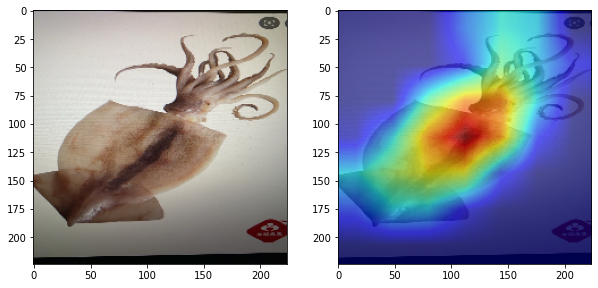

In [ ]:
# 準備圖片
FOLDER_PATH = '/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/02_進模型的圖片/train'
filenames = os.listdir(FOLDER_PATH)

idx = np.random.randint(0, len(filenames))
#img_path = os.path.join(FOLDER_PATH, filenames[idx])
img_path = 'test.jpg'
# img_path = '/content/drive/MyDrive/12_團體專題_第四組/01_圖片資料/01_原圖/頭足類圖片/魷魚002-泡鹼/IMG_7075.JPG'
print(img_path)

# 圖片預處理
img = processing_image(img_path)

# 顯示
heatmap, pred_class_name = gradcam(model, img, ) # top_bn

print('pred_class_name: ', pred_class_name)
print('heatmap.shape: ', heatmap.shape)
plot_heatmap(heatmap, img_path)

[2.0159842e-02 5.3553008e-02 1.9903484e-05 9.2492700e-01 1.3402362e-03]

bigfin squid 的機率: 0.02016
neritic squid 的機率: 0.05355
octopus 的機率: 2e-05
squid 的機率: 0.92493
cuttlefish 的機率: 0.00134


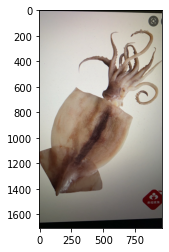

In [ ]:
img = cv2.imread(img_path)[:,:,::-1]
img_predict = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_predict = tf.keras.applications.efficientnet.preprocess_input(img_predict)
img_predict = np.array(img_predict).reshape(1, IMG_SIZE, IMG_SIZE, 3)

prob = model.predict(img_predict)[0]
print(prob, end='\n\n')

cls = [
      "bigfin squid",
      "neritic squid",
      "octopus",
      "squid",
      "cuttlefish",     
]

# 列出各種類的機率
for c, p in zip(cls, prob):
    print(c, "的機率:", round(p, 5))
    
plt.imshow(img)